In [1]:
spark

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log
85,application_1609326166272_0004,pyspark,idle,Link,Link


SparkSession available as 'spark'.

## Import modules

In [125]:
import hashlib
from datetime import datetime
from pyspark.sql import functions as F
from pyspark.sql.types import FloatType, LongType
from pyspark.sql.functions import explode
from graphframes import *
import hsfs
from hops import hdfs

## Define utility functions

In [3]:
def action_2_code(x):
    if (x == "CASH_IN"):
        node_type = 0
    elif (x == "CASH_OUT"):
        node_type = 1
    elif (x == "DEBIT"):
        node_type = 2
    elif (x == "PAYMENT"):
        node_type = 3
    elif (x == "TRANSFER"):
        node_type = 4
    elif (x == "DEPOSIT"):
        node_type = 4        
    else:
        node_type = 99
    return node_type

def timestamp_2_time(x):
    dt_obj = datetime.strptime(str(x), '%Y-%m-%d %H:%M:%S')
    return dt_obj.timestamp()

action_2_code_udf = F.udf(action_2_code)
timestamp_2_time_udf = F.udf(timestamp_2_time)

In [41]:
simname = "composite"

## Load accounts datasets as spark dataframe and perform feature engineering

In [42]:
accounts_df = spark.read\
             .option("inferSchema", "true")\
             .option("header", "true")\
             .format("csv")\
             .load("hdfs:///Projects/{}/Resources/{}/{}/accounts.csv".format(hdfs.project_name(),simname,simname))

accounts_df = accounts_df.drop('first_name')\
                        .drop('last_name')\
                        .drop('street_addr')\
                        .drop('city')\
                        .drop('state')\
                        .drop('zip')\
                        .drop('gender')\
                        .drop('birth_date')\
                        .drop('ssn')\
                        .drop('lon')\
                        .drop('lat')

In [43]:
accounts_df = accounts_df.withColumn('prior_sar',F.when(F.col('prior_sar_count') == 'true', 1).otherwise(0))\
                         .drop("prior_sar_count","acct_rptng_crncy","type","acct_stat","open_dt","bank_id","country","close_dt","dsply_nm","branch_id")

In [44]:
accounts_df.show()

+-------+---------------+--------------+---------+
|acct_id|initial_deposit|tx_behavior_id|prior_sar|
+-------+---------------+--------------+---------+
|      0|       92221.09|             1|        1|
|      1|       87897.72|             1|        0|
|      2|       71028.58|             1|        0|
|      3|       62945.84|             1|        0|
|      4|       75563.74|             1|        0|
|      5|       70246.71|             1|        0|
|      6|       89189.93|             1|        0|
|      7|       65165.64|             1|        0|
|      8|       73829.85|             1|        0|
|      9|        79169.1|             1|        0|
|     10|       95405.64|             1|        0|
|     11|       75234.34|             1|        0|
|     12|       64091.89|             1|        0|
|     13|       87790.21|             1|        0|
|     14|       80918.45|             1|        0|
|     15|       62525.32|             1|        0|
|     16|       95487.31|      

In [45]:
accounts_df.select("tx_behavior_id").dropDuplicates().show()

+--------------+
|tx_behavior_id|
+--------------+
|             1|
+--------------+

## Load transactions datasets as spark dataframe and perform feature engineering

In [46]:
transactions_df = spark.read\
             .option("inferSchema", "true")\
             .option("header", "true")\
             .format("csv")\
             .load("hdfs:///Projects/{}/Resources/{}/{}/transactions.csv".format(hdfs.project_name(),simname,simname))

transactions_df.show()

+-------+---------+---------+---------------+--------+-------------------+------+--------+
|tran_id|orig_acct|bene_acct|        tx_type|base_amt|     tran_timestamp|is_sar|alert_id|
+-------+---------+---------+---------------+--------+-------------------+------+--------+
|      1|    16410|    17545|TRANSFER-FanOut|  935.75|2020-01-01 00:00:00| false|      -1|
|      2|     5281|    12044|TRANSFER-FanOut|  839.51|2020-01-01 00:00:00| false|      -1|
|      3|     5738|     1148|TRANSFER-FanOut|  795.57|2020-01-01 00:00:00| false|      -1|
|      4|     2858|     6899|TRANSFER-FanOut|  997.98|2020-01-01 00:00:00| false|      -1|
|      5|    12766|     6586|TRANSFER-FanOut|  416.49|2020-01-01 00:00:00| false|      -1|
|      6|    10396|     1653|TRANSFER-FanOut|  979.52|2020-01-01 00:00:00| false|      -1|
|      7|      689|     8570|TRANSFER-FanOut|  927.83|2020-01-01 00:00:00| false|      -1|
|      8|     9593|    10644|TRANSFER-FanOut|  690.37|2020-01-01 00:00:00| false|      -1|

In [47]:
alert_accounts_df = spark.read\
             .option("inferSchema", "true")\
             .option("header", "true")\
             .format("csv")\
             .load("hdfs:///Projects/{}/Resources/{}/{}/alert_accounts.csv".format(hdfs.project_name(),simname,simname))

alert_accounts_df.show()
#alert_accounts_df.orderBy("alert_id").show()

+--------+--------------+-------+---------+------+--------+-----+-------+-----------+-------+
|alert_id|    alert_type|acct_id|acct_name|is_sar|model_id|start|    end|schedule_id|bank_id|
+--------+--------------+-------+---------+------+--------+-----+-------+-----------+-------+
|       0|scatter_gather|  16158|    16158|  true|       7|    0|1000000|          0|      1|
|       0|scatter_gather|   9425|     9425|  true|       7|    0|1000000|          0|      1|
|       0|scatter_gather|   2565|     2565|  true|       7|    0|1000000|          0|      1|
|       0|scatter_gather|  16244|    16244|  true|       7|    0|1000000|          0|      1|
|       0|scatter_gather|  16062|    16062|  true|       7|    0|1000000|          0|      1|
|       1|scatter_gather|  19241|    19241|  true|       7|    0|1000000|          0|      1|
|       1|scatter_gather|  16207|    16207|  true|       7|    0|1000000|          0|      1|
|       1|scatter_gather|  14585|    14585|  true|       7| 

In [48]:
alert_accounts_df.count()

820

In [49]:
alert_transactions_df = spark.read\
             .option("inferSchema", "true")\
             .option("header", "true")\
             .format("csv")\
             .load("hdfs:///Projects/{}/Resources/{}/{}/alert_transactions.csv".format(hdfs.project_name(),simname,simname))
alert_transactions_df.orderBy("alert_id").show()

+--------+--------------+------+-------+---------+---------+---------------+--------+-------------------+
|alert_id|    alert_type|is_sar|tran_id|orig_acct|bene_acct|        tx_type|base_amt|     tran_timestamp|
+--------+--------------+------+-------+---------+---------+---------------+--------+-------------------+
|       0|scatter_gather|  true|  92688|     2565|     9425|TRANSFER-FanOut| 2450.35|2020-02-02 00:00:00|
|       0|scatter_gather|  true|  50229|    16158|     2565|TRANSFER-FanOut| 2722.62|2020-01-18 00:00:00|
|       0|scatter_gather|  true|  53063|    16158|    16062|TRANSFER-FanOut| 2722.62|2020-01-19 00:00:00|
|       0|scatter_gather|  true|  86765|    16062|     9425|TRANSFER-FanOut| 2450.35|2020-01-31 00:00:00|
|       0|scatter_gather|  true|  50230|    16158|    16244|TRANSFER-FanOut| 2722.62|2020-01-18 00:00:00|
|       0|scatter_gather|  true|  89949|    16244|     9425|TRANSFER-FanOut| 2450.35|2020-02-01 00:00:00|
|       1|scatter_gather|  true|  83716|    19

In [50]:
alert_transactions_df.count()

946

In [51]:
alert_acct_id_df = alert_accounts_df.select("acct_id")
alert_related_transactions_df = transactions_df.join(
    alert_acct_id_df,
    [(alert_acct_id_df.acct_id==transactions_df.orig_acct)|(alert_acct_id_df.acct_id==transactions_df.bene_acct)],
    how="inner"
).dropDuplicates(subset=['tran_id']).drop("acct_id")
alert_related_transactions_df.show()

+-------+---------+---------+---------------+--------+-------------------+------+--------+
|tran_id|orig_acct|bene_acct|        tx_type|base_amt|     tran_timestamp|is_sar|alert_id|
+-------+---------+---------+---------------+--------+-------------------+------+--------+
|    496|     8153|     7297|TRANSFER-FanOut|  171.95|2020-01-01 00:00:00| false|      -1|
|    833|     5680|     7093|TRANSFER-FanOut|  321.03|2020-01-01 00:00:00| false|      -1|
|   1088|    12707|     4794|TRANSFER-FanOut|  159.79|2020-01-01 00:00:00| false|      -1|
|   2142|      762|     6467|TRANSFER-FanOut|  688.46|2020-01-01 00:00:00| false|      -1|
|   5300|      512|     8552|TRANSFER-FanOut|  759.93|2020-01-02 00:00:00| false|      -1|
|  17389|     5483|    16940|TRANSFER-FanOut|  551.35|2020-01-07 00:00:00| false|      -1|
|  17679|     6177|     7585|TRANSFER-FanOut|  931.99|2020-01-07 00:00:00| false|      -1|
|  18498|    10119|    14224|TRANSFER-FanOut|  667.98|2020-01-07 00:00:00| false|      -1|

In [52]:
alert_related_transactions_df.count()

14731

In [53]:
alert_related_transactions_df.where(F.col("alert_id")==-1).show()

+-------+---------+---------+---------------+--------+-------------------+------+--------+
|tran_id|orig_acct|bene_acct|        tx_type|base_amt|     tran_timestamp|is_sar|alert_id|
+-------+---------+---------+---------------+--------+-------------------+------+--------+
|    496|     8153|     7297|TRANSFER-FanOut|  171.95|2020-01-01 00:00:00| false|      -1|
|    833|     5680|     7093|TRANSFER-FanOut|  321.03|2020-01-01 00:00:00| false|      -1|
|   1088|    12707|     4794|TRANSFER-FanOut|  159.79|2020-01-01 00:00:00| false|      -1|
|   2142|      762|     6467|TRANSFER-FanOut|  688.46|2020-01-01 00:00:00| false|      -1|
|   5300|      512|     8552|TRANSFER-FanOut|  759.93|2020-01-02 00:00:00| false|      -1|
|  17389|     5483|    16940|TRANSFER-FanOut|  551.35|2020-01-07 00:00:00| false|      -1|
|  17679|     6177|     7585|TRANSFER-FanOut|  931.99|2020-01-07 00:00:00| false|      -1|
|  18498|    10119|    14224|TRANSFER-FanOut|  667.98|2020-01-07 00:00:00| false|      -1|

In [54]:
alert_related_transactions_ids = alert_related_transactions_df.select("tran_id")
non_alert_related_transactions_df = transactions_df.join(alert_related_transactions_ids, ["tran_id"], how="leftanti")
non_alert_related_transactions_df.show()

+-------+---------+---------+---------------+--------+-------------------+------+--------+
|tran_id|orig_acct|bene_acct|        tx_type|base_amt|     tran_timestamp|is_sar|alert_id|
+-------+---------+---------+---------------+--------+-------------------+------+--------+
|    148|    18881|     3076|TRANSFER-FanOut|  972.76|2020-01-01 00:00:00| false|      -1|
|    463|    19195|     2588|TRANSFER-FanOut|  590.17|2020-01-01 00:00:00| false|      -1|
|    471|     9896|     3998|TRANSFER-FanOut|  632.81|2020-01-01 00:00:00| false|      -1|
|   1238|     8751|     4701|TRANSFER-FanOut|  194.26|2020-01-01 00:00:00| false|      -1|
|   1342|     8661|    19826|TRANSFER-FanOut|  115.78|2020-01-01 00:00:00| false|      -1|
|   1580|     3637|     4171|TRANSFER-FanOut|  958.31|2020-01-01 00:00:00| false|      -1|
|   1591|     9261|     8762|TRANSFER-FanOut|   415.0|2020-01-01 00:00:00| false|      -1|
|   1645|     8979|     8966|TRANSFER-FanOut|  407.84|2020-01-01 00:00:00| false|      -1|

In [55]:
non_alert_related_transactions_df.count()

157697

In [56]:
non_alert_related_transactions_df.show()

+-------+---------+---------+---------------+--------+-------------------+------+--------+
|tran_id|orig_acct|bene_acct|        tx_type|base_amt|     tran_timestamp|is_sar|alert_id|
+-------+---------+---------+---------------+--------+-------------------+------+--------+
|    148|    18881|     3076|TRANSFER-FanOut|  972.76|2020-01-01 00:00:00| false|      -1|
|    463|    19195|     2588|TRANSFER-FanOut|  590.17|2020-01-01 00:00:00| false|      -1|
|    471|     9896|     3998|TRANSFER-FanOut|  632.81|2020-01-01 00:00:00| false|      -1|
|   1238|     8751|     4701|TRANSFER-FanOut|  194.26|2020-01-01 00:00:00| false|      -1|
|   1342|     8661|    19826|TRANSFER-FanOut|  115.78|2020-01-01 00:00:00| false|      -1|
|   1580|     3637|     4171|TRANSFER-FanOut|  958.31|2020-01-01 00:00:00| false|      -1|
|   1591|     9261|     8762|TRANSFER-FanOut|   415.0|2020-01-01 00:00:00| false|      -1|
|   1645|     8979|     8966|TRANSFER-FanOut|  407.84|2020-01-01 00:00:00| false|      -1|

In [57]:
non_alert_related_transactions_df.where(F.col("alert_id")>-1).show()

+-------+---------+---------+-------+--------+--------------+------+--------+
|tran_id|orig_acct|bene_acct|tx_type|base_amt|tran_timestamp|is_sar|alert_id|
+-------+---------+---------+-------+--------+--------------+------+--------+
+-------+---------+---------+-------+--------+--------------+------+--------+

In [67]:
demo_alert = alert_transactions_df.where(F.col("alert_id")==1).select("tran_id","orig_acct","bene_acct","base_amt")
demo_alert.show()

+-------+---------+---------+--------+
|tran_id|orig_acct|bene_acct|base_amt|
+-------+---------+---------+--------+
|  83194|    19241|    14585| 2881.62|
|  83716|    19241|      618| 2881.62|
|  88333|    19241|     7115| 2881.62|
| 110181|    19241|     8891| 2881.62|
| 127176|      618|    16207| 2593.46|
| 153122|     7115|    16207| 2593.46|
| 153123|     8891|    16207| 2593.46|
| 161662|    14585|    16207| 2593.46|
+-------+---------+---------+--------+

In [68]:
%%spark -o demo_alert

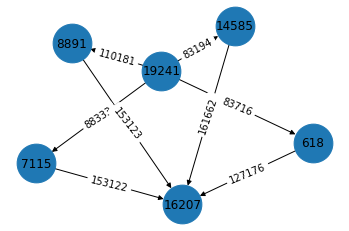

In [159]:
%%local
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import pylab

G = nx.from_pandas_edgelist(demo_alert,source='orig_acct',
                                   target='bene_acct',edge_attr=True,
                                   create_using=nx.DiGraph())

val_map = {}

values = [val_map.get(node, 0.45) for node in G.nodes()]
edge_labels=dict([((u,v,),d['tran_id']) for u,v,d in G.edges(data=True)])
red_edges = [('C','D'),('D','A')]
edge_colors = ['black' if not edge in red_edges else 'red' for edge in G.edges()]

pos=nx.spring_layout(G)
nx.draw_networkx_edge_labels(G,pos,edge_labels=edge_labels)
nx.draw(G,pos, node_size=1500, edge_color=edge_colors,edge_cmap=plt.cm.Reds, with_labels = True) #node_color = values,
pylab.show()

In [79]:
demo_sources = demo_alert.select("orig_acct").toDF("id")
demo_targets = demo_alert.select("bene_acct").toDF("id")
demo_nodes = demo_sources.union(demo_targets).dropDuplicates()
demo_nodes.show()

+-----+
|   id|
+-----+
|19241|
|  618|
|14585|
|16207|
| 7115|
| 8891|
+-----+

In [181]:
demo_nodes_array = [int(row.id) for row in demo_nodes.collect()]
sources = alert_related_transactions_df.select("orig_acct").toDF("id")
targets = alert_related_transactions_df.select("bene_acct").toDF("id")
nodes = sources.union(targets).dropDuplicates()
edges = alert_related_transactions_df.select("orig_acct","bene_acct").toDF("src", "dst")
# Now lets construct the graph
g = GraphFrame(nodes, edges)

In [182]:
max2hop = g.find("(a)-[ab]->(b); (b)-[bc]->(c)")
max2hop = max2hop.select('a.*','ab','b.*','bc','c.*').toDF("a","ab","b","bc","c")
max2hop.show()

# compute shortest paths to demo_nodes
#sp_results = g.shortestPaths(landmarks=demo_nodes_array)
#sp_results = sp_results.select("id", explode("distances"))
#max2_hops = sp_results.where((F.col("value")>=1) & (F.col("value")<=2))

+-----+--------------+-----+-------------+----+
|    a|            ab|    b|           bc|   c|
+-----+--------------+-----+-------------+----+
|17620| [17620, 2546]| 2546|  [2546, 471]| 471|
| 4617| [4617, 10070]|10070| [10070, 471]| 471|
| 4617| [4617, 10070]|10070| [10070, 471]| 471|
| 8641| [8641, 12707]|12707| [12707, 496]| 496|
| 8641| [8641, 12707]|12707| [12707, 496]| 496|
| 8118| [8118, 12707]|12707| [12707, 496]| 496|
| 8118| [8118, 12707]|12707| [12707, 496]| 496|
| 8118| [8118, 12707]|12707| [12707, 496]| 496|
| 8118| [8118, 12707]|12707| [12707, 496]| 496|
|14297|[14297, 12707]|12707| [12707, 496]| 496|
|14297|[14297, 12707]|12707| [12707, 496]| 496|
|18287|[18287, 12707]|12707| [12707, 496]| 496|
|18287|[18287, 12707]|12707| [12707, 496]| 496|
|14864| [14864, 1184]| 1184| [1184, 1088]|1088|
|11948| [11948, 6396]| 6396| [6396, 1088]|1088|
| 4138| [4138, 18299]|18299|[18299, 1088]|1088|
| 1929|  [1929, 4386]| 4386| [4386, 1088]|1088|
| 1929|  [1929, 4386]| 4386| [4386, 1088

In [183]:
max2hop_from_to_demo_nodes = max2hop.join(
    demo_nodes,
    [(demo_nodes.id==max2hop.a)|(demo_nodes.id==max2hop.b)|(demo_nodes.id==max2hop.c)],
    how="inner"
)
max2hop_from_to_demo_nodes.show()

+-----+-------------+----+------------+----+-----+
|    a|           ab|   b|          bc|   c|   id|
+-----+-------------+----+------------+----+-----+
| 2572| [2572, 8891]|8891|[8891, 8928]|8928| 8891|
|11780|[11780, 8891]|8891|[8891, 8928]|8928| 8891|
| 3751| [3751, 8891]|8891|[8891, 8928]|8928| 8891|
| 1445| [1445, 8891]|8891|[8891, 8928]|8928| 8891|
| 3862| [3862, 8891]|8891|[8891, 8928]|8928| 8891|
| 4946| [4946, 8891]|8891|[8891, 8928]|8928| 8891|
| 1647| [1647, 8891]|8891|[8891, 8928]|8928| 8891|
|10727|[10727, 8891]|8891|[8891, 8928]|8928| 8891|
|19241|[19241, 8891]|8891|[8891, 8928]|8928|19241|
|19241|[19241, 8891]|8891|[8891, 8928]|8928| 8891|
|16294|[16294, 8891]|8891|[8891, 8928]|8928| 8891|
|18400|[18400, 8891]|8891|[8891, 8928]|8928| 8891|
|18400|[18400, 8891]|8891|[8891, 8928]|8928| 8891|
|18400|[18400, 8891]|8891|[8891, 8928]|8928| 8891|
|18400|[18400, 8891]|8891|[8891, 8928]|8928| 8891|
| 2681| [2681, 8891]|8891|[8891, 8928]|8928| 8891|
| 7470| [7470, 8891]|8891|[8891

In [185]:
max2hop_from_to_demo_nodes.where((F.col("a")==19241)|(F.col("b")==19241)|(F.col("c")==19241)).show()

+-----+--------------+-----+--------------+-----+-----+
|    a|            ab|    b|            bc|    c|   id|
+-----+--------------+-----+--------------+-----+-----+
|19241| [19241, 8891]| 8891|  [8891, 8928]| 8928|19241|
|19241| [19241, 8891]| 8891|  [8891, 8928]| 8928| 8891|
|19241|[19241, 16207]|16207|[16207, 12607]|12607|19241|
|19241|[19241, 16207]|16207|[16207, 12607]|12607|16207|
|19241|[19241, 16207]|16207|[16207, 12607]|12607|19241|
|19241|[19241, 16207]|16207|[16207, 12607]|12607|16207|
|19241|[19241, 16207]|16207| [16207, 4291]| 4291|19241|
|19241|[19241, 16207]|16207| [16207, 4291]| 4291|16207|
|19241|[19241, 16207]|16207| [16207, 4291]| 4291|19241|
|19241|[19241, 16207]|16207| [16207, 4291]| 4291|16207|
|19241| [19241, 7115]| 7115| [7115, 16317]|16317|19241|
|19241| [19241, 7115]| 7115| [7115, 16317]|16317| 7115|
|19241| [19241, 7115]| 7115| [7115, 16317]|16317|19241|
|19241| [19241, 7115]| 7115| [7115, 16317]|16317| 7115|
|19241|[19241, 14585]|14585|[14585, 14558]|14558

In [ ]:

e1 = max2hop.select("ab").toDF("e")
e2 = max2hop.select("bc").toDF("e")
e = e1.union(e2)


+-------+--------------+-------+-------------+------+
|      a|            ab|      b|           bc|     c|
+-------+--------------+-------+-------------+------+
| [8767]| [8767, 18368]|[18368]| [18368, 474]| [474]|
|  [843]|  [843, 18368]|[18368]| [18368, 474]| [474]|
|[18455]|[18455, 18368]|[18368]| [18368, 474]| [474]|
|[18962]|[18962, 18368]|[18368]| [18368, 474]| [474]|
|[11649]|[11649, 18368]|[18368]| [18368, 474]| [474]|
|[11783]|[11783, 18368]|[18368]| [18368, 474]| [474]|
| [5659]| [5659, 18368]|[18368]| [18368, 474]| [474]|
|[18068]|[18068, 18368]|[18368]| [18368, 474]| [474]|
| [1467]| [1467, 18368]|[18368]| [18368, 474]| [474]|
|[17229]|[17229, 16342]|[16342]| [16342, 474]| [474]|
|  [639]|  [639, 17401]|[17401]|[17401, 1697]|[1697]|
|  [639]|  [639, 17401]|[17401]|[17401, 1697]|[1697]|
|  [639]|  [639, 17401]|[17401]|[17401, 1697]|[1697]|
|  [639]|  [639, 17401]|[17401]|[17401, 1697]|[1697]|
| [8548]| [8548, 17401]|[17401]|[17401, 1697]|[1697]|
| [8548]| [8548, 17401]|[174

+-----+--------------+-----+-------------+----+
|    a|            ab|    b|           bc|   c|
+-----+--------------+-----+-------------+----+
|17229|[17229, 16342]|16342| [16342, 474]| 474|
|11783|[11783, 18368]|18368| [18368, 474]| 474|
|18068|[18068, 18368]|18368| [18368, 474]| 474|
| 8767| [8767, 18368]|18368| [18368, 474]| 474|
| 5659| [5659, 18368]|18368| [18368, 474]| 474|
| 1467| [1467, 18368]|18368| [18368, 474]| 474|
|  843|  [843, 18368]|18368| [18368, 474]| 474|
|11649|[11649, 18368]|18368| [18368, 474]| 474|
|18455|[18455, 18368]|18368| [18368, 474]| 474|
|18962|[18962, 18368]|18368| [18368, 474]| 474|
|  639|  [639, 17401]|17401|[17401, 1697]|1697|
|  639|  [639, 17401]|17401|[17401, 1697]|1697|
|  639|  [639, 17401]|17401|[17401, 1697]|1697|
|  639|  [639, 17401]|17401|[17401, 1697]|1697|
| 8548| [8548, 17401]|17401|[17401, 1697]|1697|
| 8548| [8548, 17401]|17401|[17401, 1697]|1697|
|12685|[12685, 17401]|17401|[17401, 1697]|1697|
|12685|[12685, 17401]|17401|[17401, 1697

In [72]:
non_alert_related_transactions_df.where(F.col("orig_acct")==18881).show()

+-------+---------+---------+---------------+--------+-------------------+------+--------+
|tran_id|orig_acct|bene_acct|        tx_type|base_amt|     tran_timestamp|is_sar|alert_id|
+-------+---------+---------+---------------+--------+-------------------+------+--------+
|    148|    18881|     3076|TRANSFER-FanOut|  972.76|2020-01-01 00:00:00| false|      -1|
| 163068|    18881|    16245|TRANSFER-FanOut|  691.85|2020-02-26 00:00:00| false|      -1|
| 101496|    18881|     3170|TRANSFER-FanOut| 1008.21|2020-02-05 00:00:00| false|      -1|
| 122140|    18881|    12059|TRANSFER-FanOut|  341.63|2020-02-12 00:00:00| false|      -1|
|  81539|    18881|    12823|TRANSFER-FanOut|  547.94|2020-01-29 00:00:00| false|      -1|
| 142546|    18881|     5430|TRANSFER-FanOut|  270.05|2020-02-19 00:00:00| false|      -1|
|  22372|    18881|      349|TRANSFER-FanOut|  681.15|2020-01-08 00:00:00| false|      -1|
|  60321|    18881|    10386|TRANSFER-FanOut|  559.66|2020-01-22 00:00:00| false|      -1|

In [75]:
alert_related_transactions_df.where(F.col("orig_acct")==19241).show()

+-------+---------+---------+---------------+--------+-------------------+------+--------+
|tran_id|orig_acct|bene_acct|        tx_type|base_amt|     tran_timestamp|is_sar|alert_id|
+-------+---------+---------+---------------+--------+-------------------+------+--------+
|  65353|    19241|     9708|TRANSFER-FanOut|  361.24|2020-01-23 00:00:00| false|      -1|
| 106300|    19241|     9384|TRANSFER-FanOut|  770.13|2020-02-06 00:00:00| false|      -1|
| 144904|    19241|    16207|TRANSFER-FanOut|  484.71|2020-02-20 00:00:00| false|      -1|
|   5701|    19241|     1949|TRANSFER-FanOut|   905.6|2020-01-02 00:00:00| false|      -1|
|  44206|    19241|    10825|TRANSFER-FanOut|  331.96|2020-01-16 00:00:00| false|      -1|
|  83194|    19241|    14585|TRANSFER-FanOut| 2881.62|2020-01-29 00:00:00|  true|       1|
|  83717|    19241|    13697|TRANSFER-FanOut|  256.91|2020-01-30 00:00:00| false|      -1|
|  23169|    19241|    11561|TRANSFER-FanOut|  732.72|2020-01-09 00:00:00| false|      -1|

In [78]:
alert_related_transactions_df.where(F.col("bene_acct")==16207).show()

+-------+---------+---------+---------------+--------+-------------------+------+--------+
|tran_id|orig_acct|bene_acct|        tx_type|base_amt|     tran_timestamp|is_sar|alert_id|
+-------+---------+---------+---------------+--------+-------------------+------+--------+
| 144904|    19241|    16207|TRANSFER-FanOut|  484.71|2020-02-20 00:00:00| false|      -1|
| 153123|     8891|    16207|TRANSFER-FanOut| 2593.46|2020-02-23 00:00:00|  true|       1|
| 142543|    15681|    16207|TRANSFER-FanOut|  417.44|2020-02-19 00:00:00| false|      -1|
| 161662|    14585|    16207|TRANSFER-FanOut| 2593.46|2020-02-26 00:00:00|  true|       1|
| 127176|      618|    16207|TRANSFER-FanOut| 2593.46|2020-02-14 00:00:00|  true|       1|
|  95278|    11227|    16207|TRANSFER-FanOut|  252.57|2020-02-03 00:00:00| false|      -1|
| 153122|     7115|    16207|TRANSFER-FanOut| 2593.46|2020-02-23 00:00:00|  true|       1|
+-------+---------+---------+---------------+--------+-------------------+------+--------+

## Create a connection to Hopsworks feature store (hsfs)

In [ ]:
# Create a connection
connection = hsfs.connection()
# Get the feature store handle for the project's feature store
fs = connection.get_feature_store()

## Create accounts feature group metadata and save it in to hsfs 

In [ ]:
accounts_fg = fs.create_feature_group(name="account_features",
                                      version=1,
                                      primary_key=["acct_id"],
                                      description="node features",
                                      time_travel_format=None,
                                      statistics_config=False)
accounts_fg.save(accounts_df)

## Create transactions feature group metadata and save it in to hsfs 

In [10]:
transactions_fg = fs.create_feature_group(name="transactions_fg",
                                       version=1,
                                       primary_key=["tran_id"],
                                       description="edge features",
                                       time_travel_format=None,                                        
                                       statistics_config=False)
transactions_fg.save(transactions_df)